# A PyTorch Neural Network

We're building a Neural Net to reconstruct top quarks! Here are the imports.

In [1]:
import os
# import pickle
from itertools import cycle
import numpy as np
import vector
import torch
from matplotlib import pyplot as plt

Creating some globals to do configuration.

In [2]:
save_folder = "/depot/cms/users/colberte/ml-learning/PyTorch/SavedModels"
os.makedirs(save_folder, exist_ok=True)

batch_size = 2048
valid_batch_size = 16384
epochs = 2
learning_rate = 1.0e-4
grad_clip_value = 80.0

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
model_params = {
    "n_features": 52,
    "n_layers": 5,
    "d_layers": 256,
    "d_output": 8,
    "dropout": 0.1,
}

### Setting up Datasets

Here we load the datasets.

In [10]:
train_dataset = torch.load("data/ttbar_dilepton_2017UL_notau_train.pt", weights_only=False)
valid_dataset = torch.load("data/ttbar_dilepton_2017UL_notau_validation.pt", weights_only=False)

In [11]:
if torch.cuda.is_available():
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)
else:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, drop_last=True)

In [12]:
valid_dataloader_iterator = cycle(valid_dataloader)

Just for demo purposes, **DON'T RUN THIS!!**

In [15]:
train_dataset_real = torch.utils.data.TensorDataset(*(train_dataset[:1000000]))
train_dataloader = torch.utils.data.DataLoader(train_dataset_real, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)

### Defining the Model

Here's one way to define a Multi-Layer Perceptron (MLP) model in PyTorch.

In [7]:
class MLPModel(torch.nn.Module):
    def __init__(self, n_features, n_layers, d_layers, d_output, dropout=0.0):
        super().__init__() # IMPORTANT: This allows the `torch.nn.Module` to initialize and prepare to register our model blocks

        # This builds up the layers we want in our network
        layers = [torch.nn.Linear(n_features, d_layers), torch.nn.ReLU()]
        for idx in range(n_layers-1):
            layers.append(torch.nn.Linear(d_layers, d_layers))
            layers.append(torch.nn.ReLU())
            if (dropout > 0.0):
                layers.append(torch.nn.Dropout(dropout))
        layers.append(torch.nn.Linear(d_layers, d_output))

        self.stack = torch.nn.Sequential(*layers) # Registers our layers as a single feedforward block

    def forward(self, inputs):
        return self.stack(inputs)

In [18]:
model = MLPModel(**model_params)
model = model.to(device)

In [19]:
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 278792


### Setting up Training

Here we define a **loss function** and **optimization algorithm** that we'll use to train our model. These are also going to come from the PyTorch library.

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

In [21]:
loss_function = torch.nn.L1Loss(reduction="mean")

### Training Loop

In [22]:
train_loss = []
valid_loss = []
# min_valid_loss = float("inf")
# min_loss_epoch = 0

In [23]:
for epoch in range(1, epochs+1):
    print(f"Starting epoch {epoch}.")
    model.train()
    for batch, (jets, leptons, met, pad_mask, target) in enumerate(train_dataloader):
        optimizer.zero_grad()

        jets = jets.reshape([-1, 40])
        leptons = leptons.reshape([-1, 10])
        met = met.reshape([-1, 2])
        #pad_mask = pad_mask.to(device)
        inputs = torch.concat([jets, leptons, met], dim=-1).to(device)
        
        target = target.to(device)

        pred = model(inputs)

        loss = loss_function(pred, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value) # gradient clipping
        optimizer.step()

        if (batch % 10 == 0):
            train_loss_number = loss.detach().to("cpu").item()
            train_loss.append(train_loss_number)

    model.eval()
    with torch.no_grad():
        jets_valid, leptons_valid, met_valid, pad_mask_valid, target_valid = next(valid_dataloader_iterator)
        jets_valid = jets_valid.reshape([-1, 40])
        leptons_valid = leptons_valid.reshape([-1, 10])
        met_valid = met_valid.reshape([-1, 2])
        #pad_mask_valid = pad_mask_valid.to(device)
        inputs_valid = torch.concat([jets_valid, leptons_valid, met_valid], dim=-1).to(device)
        
        target_valid = target_valid.to(device)

        pred_valid = model(inputs_valid)

        loss_valid = loss_function(pred_valid, target_valid)

        valid_loss_number = loss_valid.detach().to('cpu').item()
        valid_loss.append(valid_loss_number)

        # if (valid_loss_number <= min_valid_loss):
        #     min_valid_loss = valid_loss_number
        #     min_loss_epoch = epoch
        #     # Save model with lowest validation loss
        #     torch.jit.script(model).save(save_folder+"/best_mlp.pt")

print("Finished.")

Starting epoch 1.
Starting epoch 2.
Finished.


In [24]:
torch.jit.script(model).save(save_folder+"/final_mlp.pt")

### Evaluating the Results

We can look at how training proceeded by plotting the loss.

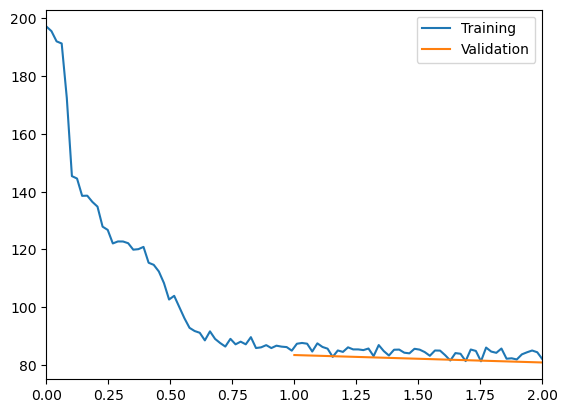

In [25]:
epochs_list = np.arange(1, epochs+1)
steps_list = np.linspace(0, epochs, len(train_loss))

fig, ax = plt.subplots()

ax.set_xlim(0, epochs)
#ax.set_ylim(bottom=0)

ax.plot(steps_list, train_loss, label="Training")
ax.plot(epochs_list, valid_loss, label="Validation")

ax.legend()

plt.show()
plt.close()

That's some pretty good training! Now, try to actually plot the results! Use the next batch of validation data to compare our saved model's predictions to the true values.

### Wrapping Up

Hope this was fun, y'all should play with it and explore!